Есть статистика поездок водителей по маршрутам с развозкой заказов в детализации по направлениям за подгода. Статистика - это фактическое время доставки груза на адрес в определенную дату в определенном направлении. Направление - это название главной дороги, вдоль которой проходит маршрут, например, Ленинградское шоссе.

На последовательность посещения адресов влияет не только направление, но и смена доставки и вид доставки - эти характеристики вместе образуют группы, внутри которых будем строить модель очередности посещения адресов.

До сих пор водитель сам выбирал последовательность посещения точек, имея в руках маршрутный лист с адресами доставки.

Требуется на основании статистики поездок составить очередь из всех адресов, так чтобы в маршрутном листе адреса оказывались в виде ранжированного списка с рекомендацией водителю - в какой последовательности посещать адреса.

После составления списка необходимо оценить ошибки модели в сравнении с реальной последовательностью посещения точек доставки и сделать вывод о полезности рекомендаций водителям.

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import  mode

Считываю данные, оставляю только необходимые столбцы

In [ ]:
df = pd.read_csv('Адвантум.csv', parse_dates = True, usecols = ['МаршрутныйЛистНомер',
                                                                'АдресДоставкиНаименование',
                                                                'ПрибытиеТС',
                                                                'Направление',
                                                                'ВидДоставки',
                                                                'СменаДоставки'
                                                               ])
df = df.dropna()
df = df[(df['АдресДоставкиНаименование'] != 'САМОВЫВОЗ') &
         (df['АдресДоставкиНаименование'] != 'ЕВРОТРЕ')

       ]

df.head(3)

,МаршрутныйЛистНомер,АдресДоставкиНаименование,ПрибытиеТС,Направление,ВидДоставки,СменаДоставки
112,МСК311920,Здоровье плюс ООО Краснознаменск4,02.11.2023 11:37:31,Область Минское,До Аптеки,Доставка на дату
113,МСК311920,РИГЛА724,02.11.2023 9:48:03,Область Минское,До Аптеки,Доставка на дату
117,МСК311920,АВЕ-12282,02.11.2023 9:31:41,Область Минское,До Аптеки,Доставка на дату


Преобразую время доставки в минуты для выстаривания последовательности посещения адресов по минутам

In [ ]:
df['День'] = df['ПрибытиеТС'].str.split().str[0]
df['Время'] = df['ПрибытиеТС'].str.split().str[1]
df['Час'] = df['Время'].str.split(':').str[0].astype (int)
df['Минуты'] = df['Время'].str.split(':').str[1].astype (int)
df['ВремяДоставки'] = df['Час'] * 60  + df['Минуты']
df = df.sort_values(by = ['МаршрутныйЛистНомер','День','Час'])

df.head()

,МаршрутныйЛистНомер,АдресДоставкиНаименование,ПрибытиеТС,Направление,ВидДоставки,СменаДоставки,День,Время,Час,Минуты,ВремяДоставки
350736,МСК297380,СПОТ9,01.09.2023 5:50:11,Область Горьковское,До Аптеки,Доставка на дату,01.09.2023,5:50:11,5,50,350
350761,МСК297380,МЕЛЗДРАВ 5 ООО Москва173,01.09.2023 5:49:01,Область Горьковское,До Аптеки,Доставка на дату,01.09.2023,5:49:01,5,49,349
350766,МСК297380,ЭРКА3917,01.09.2023 5:49:06,Область Горьковское,До Аптеки,Доставка на дату,01.09.2023,5:49:06,5,49,349
350728,МСК297380,ИСТР12,01.09.2023 6:21:19,Область Горьковское,До Аптеки,Доставка на дату,01.09.2023,6:21:19,6,21,381
350747,МСК297380,АЗО7,01.09.2023 6:31:56,Область Горьковское,До Аптеки,Доставка на дату,01.09.2023,6:31:56,6,31,391


Сколько всего уникальных адерсов доставки в данных?

In [ ]:
df = df.sort_values(by = ['МаршрутныйЛистНомер','День','ВремяДоставки'],ascending = True)

df['АдресДоставкиНаименование'].nunique()

9441

Каждый день адреса посещаются в разной последовательности и  общее количество точек посещений тоже разное. Поэтому обычный целочисленный ранг адреса неинформативный, у одного и того же адреса в разные дни может быть 5 очередь из 10 адресов или 65 очередь из 70 адресов.

 Считаю процентный ранг каждого адреса внутри дня. Чем меньше процентный ранг, тем  раньше очередь посещения адреса.

In [ ]:
df['rank'] = df.groupby(['МаршрутныйЛистНомер','День'])['ВремяДоставки']. rank ().round(0)
df['КвоТочек'] = df.groupby(['МаршрутныйЛистНомер','День'])['АдресДоставкиНаименование'].transform('count')
df['%rank'] = df['rank']/df['КвоТочек']
df.head()

,МаршрутныйЛистНомер,АдресДоставкиНаименование,ПрибытиеТС,Направление,ВидДоставки,СменаДоставки,День,Время,Час,Минуты,ВремяДоставки,rank,КвоТочек,%rank
350761,МСК297380,МЕЛЗДРАВ 5 ООО Москва173,01.09.2023 5:49:01,Область Горьковское,До Аптеки,Доставка на дату,01.09.2023,5:49:01,5,49,349,2.0,70,0.028571
350766,МСК297380,ЭРКА3917,01.09.2023 5:49:06,Область Горьковское,До Аптеки,Доставка на дату,01.09.2023,5:49:06,5,49,349,2.0,70,0.028571
350736,МСК297380,СПОТ9,01.09.2023 5:50:11,Область Горьковское,До Аптеки,Доставка на дату,01.09.2023,5:50:11,5,50,350,3.0,70,0.042857
350728,МСК297380,ИСТР12,01.09.2023 6:21:19,Область Горьковское,До Аптеки,Доставка на дату,01.09.2023,6:21:19,6,21,381,4.0,70,0.057143
350747,МСК297380,АЗО7,01.09.2023 6:31:56,Область Горьковское,До Аптеки,Доставка на дату,01.09.2023,6:31:56,6,31,391,5.0,70,0.071429


Даже процентный ранг все еще не помогает присовить очередь каждому адресу, так как он слишком вариативный для каждого адреса.

Считаю статистики процентного ранга каждого адреса внутри группы, определяемой направлением, видом доставки, сменой доставки.

Планирую использовать все квартили процентного ранга каждого адреса, а не только среднее или медиану, так как среди всех 9 тыс адресов повторы медиан процентного ранга не дадут мне выстроить очередь из адресов - будут адреса с одинаковым средним процентным рангом.

Если машина поехала по 10 или менее адресам, то это низкозагруженный рейс в сравнении с 70 адресами и последовательность посещения этих 10 адресов не дает нам информации о статистике очередности, поэтому не берем для расчета такие маршрутные листы.

In [ ]:
#Отбираем МЛ с нагрузкой более 10 точек и считаем статистики % ранга
df10 = df[(df['КвоТочек'] >= 10)]

#агрегатная функиция - описательная статистика
agg_func_math = {'%rank': 'describe'}

#колонки для группировки
columns = ['АдресДоставкиНаименование','Направление','ВидДоставки','СменаДоставки']

#статистика по каждому (адресу доставки + направление + вид доставки + смена доставки)
df_stat = df10.groupby(columns).agg(agg_func_math).round(2).reset_index().fillna(0)

#удаление мультииндекса столбца
df_stat.columns = [tup[1] if tup[1] else tup[0] for tup in df_stat.columns]

df_stat.head(3)

,АдресДоставкиНаименование,Направление,ВидДоставки,СменаДоставки,count,mean,std,min,25%,50%,75%,max
0,2СТ 4,Москва Вернадского,До Аптеки,Ночная доставка,3.0,0.45,0.02,0.44,0.44,0.45,0.46,0.47
1,2СТ 4,Москва Профсоюзная,До Аптеки,Доставка на дату,1.0,0.04,0.00,0.04,0.04,0.04,0.04,0.04
2,2СТ 4,Москва Профсоюзная,До Аптеки,Ночная доставка,5.0,0.98,0.04,0.91,1.00,1.00,1.00,1.00


Теперь для каждого адреса внутри группы  есть квартили процентного ранга, из которых можно сделать синтетический ранг как произведение квартилей.
Сортировка по этому синтетическому рангу позволит выстроить очередность посещения точек.
Чем больше значение синтетического ранга, тем ближе адрес к концу очереди.

In [ ]:
#ранжирование внутри группы по четырем статистикам
#чем выше ранг модели тем ближе адрес к концу списка
cols = ['Направление','ВидДоставки','СменаДоставки']

df_stat['rank_max'] = df_stat.groupby(cols)['max']. rank ().round(0)
df_stat['rank_75'] = df_stat.groupby(cols)['75%']. rank ().round(0)
df_stat['rank_50'] = df_stat.groupby(cols)['50%']. rank ().round(0)
df_stat['rank_25'] = df_stat.groupby(cols)['25%']. rank ().round(0)

#синтетический ранг для многоуровневой сортировки
df_stat['prod_rank'] = df_stat['rank_max'] * df_stat['rank_75'] * df_stat['rank_50'] * df_stat['rank_25']

#пересчет модельного ранга на основе синтетического для снижения уровня числа
df_stat['model_rank'] = df_stat.groupby(cols)['prod_rank']. rank ().round(0)

df_stat.head()

,АдресДоставкиНаименование,Направление,ВидДоставки,СменаДоставки,count,mean,std,min,25%,50%,75%,max,rank_max,rank_75,rank_50,rank_25,prod_rank,model_rank
0,2СТ 4,Москва Вернадского,До Аптеки,Ночная доставка,3.0,0.45,0.02,0.44,0.44,0.45,0.46,0.47,16.0,16.0,16.0,16.0,65536.0,16.0
1,2СТ 4,Москва Профсоюзная,До Аптеки,Доставка на дату,1.0,0.04,0.00,0.04,0.04,0.04,0.04,0.04,2.0,8.0,8.0,12.0,1536.0,4.0
2,2СТ 4,Москва Профсоюзная,До Аптеки,Ночная доставка,5.0,0.98,0.04,0.91,1.00,1.00,1.00,1.00,50.0,52.0,54.0,54.0,7581600.0,54.0
3,2СТ 4,Область Киевское,До Аптеки,Ночная доставка,1.0,1.00,0.00,1.00,1.00,1.00,1.00,1.00,40.0,40.0,40.0,41.0,2624000.0,41.0
4,3 А ООО Дмитров,Область Дмитровское,До Аптеки,Доставка на дату,18.0,0.30,0.19,0.07,0.22,0.30,0.34,0.94,259.0,122.0,138.0,119.0,518902356.0,158.0


Присоеднияю  к основной таблице с адресами их посчитанные синтетические ранги - они определяют очередность посещения адреса внутри группы.

Помним о том, что в списке 9,5 тыс адресов, каждый со своим номером очереди. В реальности машина поедет макисмум по 70 адресам за день, поэтому модельный номер очереди поможет выстроить порядок посещения адреса - по возрастанию модельного номера очереди, но саму очередь нужно будет пересчитать.

Например в маршрутном листе будут адреса с модельными номерами  по возрастанию 5, 45, 234. Реальная очередь этих адресов будет 1,2,3.

In [ ]:
columns = ['АдресДоставкиНаименование','Направление','ВидДоставки','СменаДоставки','model_rank']
cols = ['АдресДоставкиНаименование','Направление','ВидДоставки','СменаДоставки']

df_res = df10.merge(df_stat[columns], on = cols )
df_res.head(3)

,МаршрутныйЛистНомер,АдресДоставкиНаименование,ПрибытиеТС,Направление,ВидДоставки,СменаДоставки,День,Время,Час,Минуты,ВремяДоставки,rank,КвоТочек,%rank,model_rank
0,МСК297380,МЕЛЗДРАВ 5 ООО Москва173,01.09.2023 5:49:01,Область Горьковское,До Аптеки,Доставка на дату,01.09.2023,5:49:01,5,49,349,2.0,70,0.028571,463.0
1,МСК297720,МЕЛЗДРАВ 5 ООО Москва173,02.09.2023 12:41:45,Область Горьковское,До Аптеки,Доставка на дату,02.09.2023,12:41:45,12,41,761,71.0,72,0.986111,463.0
2,МСК298450,МЕЛЗДРАВ 5 ООО Москва173,06.09.2023 13:33:29,Область Горьковское,До Аптеки,Доставка на дату,06.09.2023,13:33:29,13,33,813,64.0,65,0.984615,463.0


In [ ]:
# реальный модельный ранг нужно пересчитывать тк в МЛ попадают не все адреса
df_res['count_model_rank'] = df_res.groupby(['МаршрутныйЛистНомер','День'])['model_rank']. rank ().round(0)
df_res.head()

,МаршрутныйЛистНомер,АдресДоставкиНаименование,ПрибытиеТС,Направление,ВидДоставки,СменаДоставки,День,Время,Час,Минуты,ВремяДоставки,rank,КвоТочек,%rank,model_rank,count_model_rank
0,МСК297380,МЕЛЗДРАВ 5 ООО Москва173,01.09.2023 5:49:01,Область Горьковское,До Аптеки,Доставка на дату,01.09.2023,5:49:01,5,49,349,2.0,70,0.028571,463.0,36.0
1,МСК297720,МЕЛЗДРАВ 5 ООО Москва173,02.09.2023 12:41:45,Область Горьковское,До Аптеки,Доставка на дату,02.09.2023,12:41:45,12,41,761,71.0,72,0.986111,463.0,38.0
2,МСК298450,МЕЛЗДРАВ 5 ООО Москва173,06.09.2023 13:33:29,Область Горьковское,До Аптеки,Доставка на дату,06.09.2023,13:33:29,13,33,813,64.0,65,0.984615,463.0,38.0
3,МСК298767,МЕЛЗДРАВ 5 ООО Москва173,07.09.2023 7:20:21,Область Горьковское,До Аптеки,Доставка на дату,07.09.2023,7:20:21,7,20,440,2.0,68,0.029412,463.0,38.0
4,МСК299076,МЕЛЗДРАВ 5 ООО Москва173,08.09.2023 5:46:41,Область Горьковское,До Аптеки,Доставка на дату,08.09.2023,5:46:41,5,46,346,2.0,77,0.025974,463.0,41.0


Теперь нужно проверить, как работает наша модель - насколько реальная очередность посещения адресов отличается от модельной?

Оценивать будем на том же наборе данных. Разницу считать в ранговых пунктах.

Считаю разницу в ранговых пунктах между реальной очередностью посещения точки и модельной

In [ ]:
df_res['delta'] = abs(df_res['rank'] - df_res['count_model_rank'])
df_res.head()

,МаршрутныйЛистНомер,АдресДоставкиНаименование,ПрибытиеТС,Направление,ВидДоставки,СменаДоставки,День,Время,Час,Минуты,ВремяДоставки,rank,КвоТочек,%rank,model_rank,count_model_rank,delta
0,МСК297380,МЕЛЗДРАВ 5 ООО Москва173,01.09.2023 5:49:01,Область Горьковское,До Аптеки,Доставка на дату,01.09.2023,5:49:01,5,49,349,2.0,70,0.028571,463.0,36.0,34.0
1,МСК297720,МЕЛЗДРАВ 5 ООО Москва173,02.09.2023 12:41:45,Область Горьковское,До Аптеки,Доставка на дату,02.09.2023,12:41:45,12,41,761,71.0,72,0.986111,463.0,38.0,33.0
2,МСК298450,МЕЛЗДРАВ 5 ООО Москва173,06.09.2023 13:33:29,Область Горьковское,До Аптеки,Доставка на дату,06.09.2023,13:33:29,13,33,813,64.0,65,0.984615,463.0,38.0,26.0
3,МСК298767,МЕЛЗДРАВ 5 ООО Москва173,07.09.2023 7:20:21,Область Горьковское,До Аптеки,Доставка на дату,07.09.2023,7:20:21,7,20,440,2.0,68,0.029412,463.0,38.0,36.0
4,МСК299076,МЕЛЗДРАВ 5 ООО Москва173,08.09.2023 5:46:41,Область Горьковское,До Аптеки,Доставка на дату,08.09.2023,5:46:41,5,46,346,2.0,77,0.025974,463.0,41.0,39.0


Вывожу статистику разницы модели и факта по всем высоконагруженным маршрутным листам ( где более 10 точек посещения). Медианное отклонение - 3 ранговых пункта из 400 тыс случаев сравнения факта и модели.

In [ ]:
df_res['delta'].describe()

count    358750.000000
mean          6.791964
std           9.508660
min           0.000000
25%           1.000000
50%           3.000000
75%           8.000000
max          92.000000
Name: delta, dtype: float64

Визуализация качества моделирования очередности посещения адресов.
По горизонтальной оси - отклонения модели от факта в пунктах очереди.
По верикали количество встречаемости таких отклонений.

array([[<Axes: title={'center': 'delta'}>]], dtype=object)

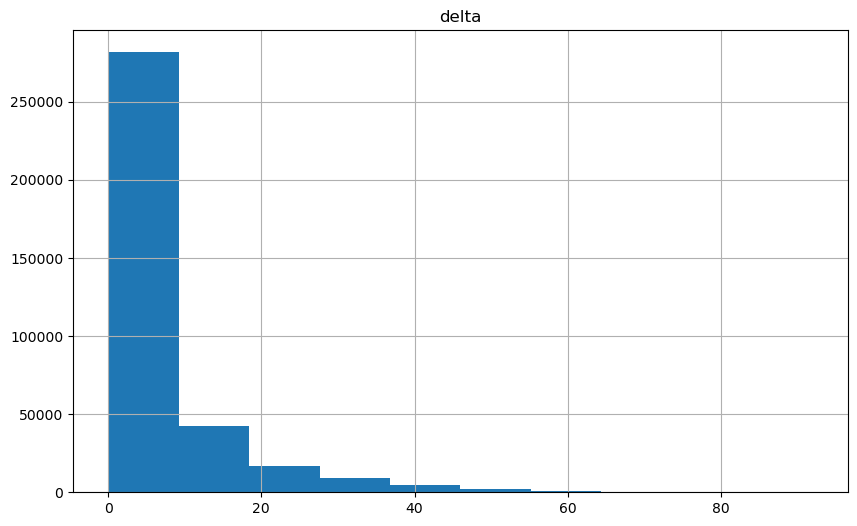

In [ ]:
#распределение ошибок рангов для маршрутов более 10 точек
df_res.hist (column = 'delta', figsize=(10, 6))

Итоговый список с рекомендуемой очередностью посещеня адресов внутри групп Направввление, ВидДоставки, СменаДоставки, выглядит так:

In [ ]:
df_stat.head()

,АдресДоставкиНаименование,Направление,ВидДоставки,СменаДоставки,model_rank
12875,апаве 383,Москва Алтуфьевское,До Аптеки,Доставка на дату,1.0
11716,Эндентика МЦ ООО Москва1,Москва Алтуфьевское,До Аптеки,Доставка на дату,2.0
3523,ДОКТОРМ 1,Москва Алтуфьевское,До Аптеки,Доставка на дату,3.0
6931,НЕО717,Москва Алтуфьевское,До Аптеки,Доставка на дату,4.0
1828,АПТО1631,Москва Алтуфьевское,До Аптеки,Доставка на дату,5.0


Выводы - модель рабочая, можно пользоваться ранжированным списком адресов внутри групп  - направление, вид доставки, смена доставки для рекомендаций водителю.

Если медианная ошибка в 3 пункта очереди высокая - необходимо добавить детализацию в данные кроме перечисленных полей. Существует оптовая и розничная доставка - они влияют на порядок расположения товара в машине и водитель едет на тот адрес, товар для которого планирует отдать  первую очередь - этот фактор мы до сих пор не учитывали.

Помня о том, что статистика дана за период, когда водитель сам определял очередность посещения точек, можем предположить, что внешние обстоятельства влияли на маршрут и полностью исключить большие отклонения между моделью и фактом мы не сможем, можем стремится к снижению средней ошибки.